In [ ]:
####
#
# Majority of the code is sampled from https://scikit-learn.org/stable/modules/cross_validation.html 
# it gives a lot of examples and so everything was taken from here. Code taken from other sources will be acknowledged next
# to the code snipets. The part where I was doing code on my own was image augmentation, choosing what hyper-parameters
# value to pick.
#
###

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import cv2 as cv
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, plot_roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from skimage.feature import hog
import os

In [45]:
####
#
# Specifying the paths of the datasets and the labels.
#
####

path_train = os.listdir("./nih-malaria/cell_images/train/")
path_val = os.listdir("./nih-malaria/cell_images/val/")
path_test = os.listdir("./nih-malaria/cell_images/test/")

classes = {'parasitized':0,'uninfected':1}

In [47]:
####
#
# Create lists that will contain 1-D flattened images. 
#
####

x_train=[]
x_test = []
x_val = []
y_train = []
y_test = []
y_val = []


####
# 
# Training data
#
# Loading each image from the directory resizing images, applying augmentation(grayscale, rotations and using HOG),
# Appending the augmented images into a list containing the flattened images and appending a label of the images into separate
# array. 
# Printing out the number of images loaded
#
####

for cls in classes:
    path_train = './nih-malaria/cell_images/train/'+cls
    for file in os.listdir(path_train):
        img = cv.imread(path_train+'/'+file)
        img = cv.resize(img, (64,128), interpolation = cv.INTER_AREA)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), visualize=True, multichannel=True)
        imgToArr = hog_image.flatten();
        x_train.append(imgToArr)
        y_train.append(classes[cls])
        
        imgrot = cv.rotate(img,cv.ROTATE_180)
        fd, hog_image = hog(imgrot, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), visualize=True, multichannel=True)
        imgToArr = hog_image.flatten();
        x_train.append(imgToArr)
        y_train.append(classes[cls])

        
print("x_train: ",len(x_train))
        
        
####
#
# Testing data
#
# Resizing each image, converting to grayscale and flattening image and appending to list and a label to another list
# Printing out the total image count
#
####

for cls in classes:
    path_test = './nih-malaria/cell_images/test/'+cls
    for file in os.listdir(path_test):
        img = cv.imread(path_test+'/'+file)
        img = cv.resize(img, (64,128), interpolation = cv.INTER_AREA)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), visualize=True, multichannel=True)
        imgToArr = hog_image.flatten();
        x_test.append(imgToArr)
        y_test.append(classes[cls])
    
print("x_test: ",len(x_test))

for cls in classes:
    path_val = './nih-malaria/cell_images/val/'+cls
    for file in os.listdir(path_val):
        img = cv.imread(path_val+'/'+file)
        img = cv.resize(img,(64,128), interpolation = cv.INTER_AREA)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), visualize=True, multichannel=True)
        imgToArr = hog_image.flatten();
        x_val.append(imgToArr)
        y_val.append(classes[cls])
        
print("x_val: ",len(x_val))

C:\Users\petru\AppData\Local\Temp\ipykernel_13768\2114591484.py:31: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
C:\Users\petru\AppData\Local\Temp\ipykernel_13768\2114591484.py:38: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(imgrot, orientations=9, pixels_per_cell=(8,8),


x_train:  44092


C:\Users\petru\AppData\Local\Temp\ipykernel_13768\2114591484.py:62: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),


x_test:  2758


C:\Users\petru\AppData\Local\Temp\ipykernel_13768\2114591484.py:75: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),


x_val:  2754


0


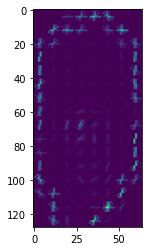

In [48]:
####
#
# Checking if the images are loaded and augmented by reshaping the image.
#
####

img1=x_train[0].reshape(128,64)
plt.imshow(img1)
print(y_train[5000])

In [49]:
####
#
# Model only takes in data that is a 1-D array. Because the images are in lists, I convert the lists into arrays using
# numpy libary that will convert lists into arrays. The same is done with label lists
#
####

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [50]:
####
#
# Data normalization scales the values from 0-255 range into a 0-1 value range. This will reduce compuational load as numbers
# can get really big.
#
####

x_test = x_test/255.0
x_train =x_train/255.0
x_val =x_val/255.0

In [51]:
####
#
# XGBoost does not support casual numpy arrays. It supports a DMatrix input format. We specify the data and the labels.
#
####

dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest=xgb.DMatrix(data=x_test,label=y_test)
dval=xgb.DMatrix(data=x_val,label=y_val)

In [7]:
####
#
# XGBoost supports a wide variety of hyperparameters that are tunable and are displayed bellow, but I will only use a few.
#
####

print(XGBClassifier())

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


In [70]:
####
#
# Specifying a range of parameters that will be tested in RandomizedSearchCV. All combinations will not be tested
# but as the search space is big and finding every possible combination will take too long.
# 
# learning_rate - affects the weights that define how conservative the model stays, lower the number means more conservative. 
# gamma - is regularization parameter and defines how conservative the model should stay.
# max-depth - defines the depth of the tree, deeper tree means a more complex model.
# n_iterations - the number of iterations or epochs.
# min_child_weight - which regularizes the depth of trees by stating whats the minimum weight required to make a new node.
#
# More about hyperparameters: https://xgboost.readthedocs.io/en/stable/parameter.html
#
####

params={
    "learning_rate":[2,1,0.1,0.01],
    "gamma":[0.1,0.3,0.5],
    "max_depth":[2,3,5,7],
    "n_iterations":[20,50,80],
    "min_child_weight":[0,1,2,5]
}

In [71]:
####
#
# Defining the model and specifying the objective function logistic regression which is for binary classification,
# output probability. Tree_method = hist, in the documentation it specifies "Faster histogram optimized approximate greedy algorithm.",
#  "It’s recommended to try hist and gpu_hist for higher performance with large dataset." 
#
#  Documentation: https://xgboost.readthedocs.io/en/stable/parameter.html
#
####

model=xgb.XGBClassifier(objective="binary:logistic",tree_method='hist')

In [72]:
####
#
# Implementing RandomizedSearchCV. It will randomly assign combinations of the given parameters.
# n_iter - "Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution."
# n_jobs - "Number of jobs to run in parallel.-1 means using all processors."
# cv - cross validation 
#
####

random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=3,scoring="roc_auc",n_jobs=-1,cv=3)
random_search.fit(x_test,y_test)

F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "n_iterations" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:38:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                    

In [73]:
####
#
# Getting the results of RandomizedSearchCV
#
####

random_search.best_params_

{'n_iterations': 50,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.3}

In [74]:
####
#
# Defining the model and inserting parameters goten from RandomizedSearchCV.
#
####

model=XGBClassifier(objective='binary:logistic',max_depth=5,learning_rate=0.1,gamma=0.3,n_estimators=50,min_child_weight=2,tree_method='hist',verbose=2)

In [75]:
####
#
# Training the model with training data
# evaluation metrics will be given after each epoch. 
# AUC - Receiver Operating Characteristic Area under the Curve.
#
# ERROR - "Binary classification error rate. It is calculated as #(wrong cases)/#(all cases).
# For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 
# as positive instances, and the others as negative instances."
# 
# eval_set passes data to the model to evaluate the performance during the traning
#
####

clf = model.fit(x_train,y_train,
          eval_metric=['auc','error'],
          eval_set=[(x_val,y_val)]
         )
#2.17.33

[09:41:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.79652	validation_0-error:0.25381
[1]	validation_0-auc:0.83879	validation_0-error:0.23166
[2]	validation_0-auc:0.84596	validation_0-error:0.22694
[3]	validation_0-auc:0.86339	validation_0-error:0.21750
[4]	validation_0-auc:0.87485	validation_0-error:0.20733
[5]	validation_0-auc:0.88442	validation_0-error:0.20407
[6]	validation_0-auc:0.89018	validation_0-error:0.20044
[7]	validation_0-auc:0.89484	validation_0-error:0.19499
[8]	validation_0-auc:0.89731	validation_0-error:0.19245
[9]	validation_0-auc:0.90000	validation_0-error:0.19208
[10]	validation_0-auc:0.90292	validation_0-er

In [79]:
####
#
# predictions contain predictions of the given images.
# accuracy show the percentage of how well the labels y_test match the classified predictions values.
#
####

predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

0.8582306018854242


In [80]:
####
#
# Getting various metrics measurements of how well the model was able to predict test labels
# classes = {'parasitized':0,'uninfected':1}
# f1-score - the harmonic mean between precision and recall
# Precision = tp/tp+fp - proportion of positive results that were correctly classified
#  recall/sensitivity - ability to correctly identify positive casses
####

labels = ['parasitized','uninfected']
clf_rep = classification_report(y_test,predictions)
print(clf_rep)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1379
           1       0.85      0.87      0.86      1379

    accuracy                           0.86      2758
   macro avg       0.86      0.86      0.86      2758
weighted avg       0.86      0.86      0.86      2758



In [81]:
cm = confusion_matrix(y_test,predictions)
print(cm)

[[1167  212]
 [ 179 1200]]


In [82]:
####
#
# These were tests made by trial and error using various methods. I show the hyperparameters with augmentation method
# and accuracy. This is not some meaningfull things, but just to show that many variations of augmentation and hyperparameter
# tuninng was done. 
#
####


##acuracy with {'max_depth': 7, 'learning_rate': 0.25, 'gamma': 0.1} and only histogram equalization is 0.8599 after trying few more times it's 0.729
##accuracy with  {'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0}  and knn  K= 9  is 0.8127
##accuracy with  {'max_depth': 7, 'learning_rate': 0.25, 'gamma': 0.1}  and knn K= 9  is 0.8341
##accuracy with  {'max_depth': 7, 'learning_rate': 0.25, 'gamma': 0.2}  and knn K= 9  is 0.8153
##accuracy with {'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.3} and knn K =12 is 0.8229
##accuracy with {'max_depth': 4, 'learning_rate': 0.25, 'gamma': 0} and histogram equalization is less than 60%
##accuracy with {'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1} and clahe is 0.5083
##accuracy with {'max_depth': 7, 'learning_rate': 0.25, 'gamma': 0.1} and clahe is  0.5003
#accuracy with {'max_depth': 6, 'learning_rate': 0.25, 'gamma': 0.2} and color segmentation 7-200 is 74%
#accuracy with {'max_depth': 6, 'learning_rate': 0.25, 'gamma': 0.2} and color segmentation 1-200 is 72%
#accuracy with {'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2} and gray+median is 81 (Overfitting, training is 89)
#accuracy with {max_depth=6,learning_rate=0.1,gamma=0.2, n_estimators=200,colsample_bytree=0.5,min_child_weight=4} and gray+median is  81
#accuracy with {max_depth=6,learning_rate=0.1,gamma=0.2,colsample_bytree=0.5,min_child_weight=4,subsample = 0.5, n_estimators=100} and gray+median is 78
#accuracy with{'n_iterations': 200,'max_depth': 6,'learning_rate': 0.3,'gamma': 0.2,'eta': 0.3}gray+median is 84\
#accuracy with {'n_iterations': 100,'max_depth': 20,'learning_rate': 0.2,'gamma': 0.1,'eta': 0.05} and knn+infected parts segmentation is  81
#accuracy with (objective='binary:logistic',max_depth=6,learning_rate=0.2,gamma=0,eta=0.3,min_child_weight=10,n_estimators=200) knn+infected parts segmentation is
#Acc (objective='binary:logistic',max_depth=20,learning_rate=0.2,gamma=0,eta=0.2,min_child_weight=5,n_estimators=100) +rotations is 86.8
#Acc (objective='binary:logistic',max_depth=6,learning_rate=0.2,gamma=0.2,eta=0.2,min_child_weight=5,n_estimators=200) +rotation+ gauss is 86.7

In [83]:
####
#
# Applying K-fold cross validation to get an average accuracy of predictions using unseen data.
# K-fold cross validation will give a more robust result. Ussualy 3,5,10 folds are most common. 
# Because my testing set is not large I will use 3 folds. The images will be shuffled 
# specifying a number in random_state will give consistent results. For why this happens  
#
# Code is taken from https://scikit-learn.org/stable/modules/cross_validation.html 
#
###

kfold = KFold(n_splits=5, random_state=7,shuffle=True)
accuracies = cross_val_score(clf,x_test,y_test, cv =kfold)

print("5 fold cross validation score: ",accuracies.mean())

F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:16] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:46:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:46:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:47:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:27] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:47:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:47:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5 fold cross validation score:  0.8274165548804545


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


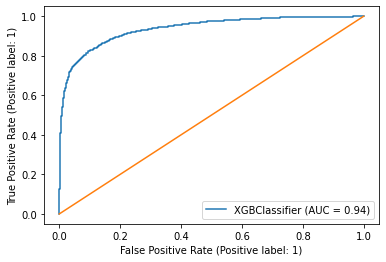

In [84]:
####
#
# AUC-ROC curve.
#
#### 
plot_roc_curve(clf, x_test, y_test)
plt.plot([0,1])

In [85]:
####
#
# Save the model to reuse later without the need of retraining
#
####

model.save_model("XGBoost.txt")

In [37]:
####
#
# Load a saved model to reuse
#
####

model2 = XGBClassifier(objective='binary:logistic',max_depth=7,learning_rate=0.3,gamma=0.02,min_child_weight=5,n_estimators=50,tree_method='hist')
model2.load_model("XGBoost.txt")

In [ ]:
####
#
# Testing that the model is loaded
#
####
predictions2 = model2.predict(x_test)
accuracy2 = accuracy_score(y_test,predictions2)
print(accuracy2)